<a href="https://colab.research.google.com/github/Nram94/simulacion-modelacion-python/blob/main/Semana07_AplicacionesII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intercambiador de Coraza y Tubos

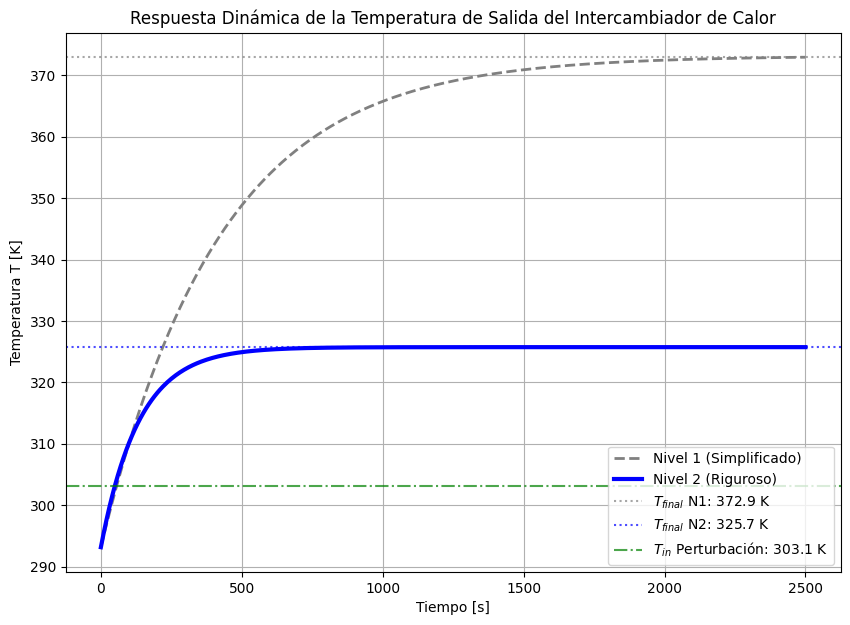


--- RESULTADOS CLAVE DEL ESTADO ESTACIONARIO ---
Temperatura de Entrada (Nueva): 303.1 K (30.0°C)
--------------------------------------------------
🥉 Nivel 1 (Simplificado): T_final = 372.9 K (99.8°C)
🥈 Nivel 2 (Riguroso): T_final = 325.7 K (52.6°C)
--------------------------------------------------
Análisis:
El Nivel 1 ignora la convección, asumiendo que el fluido se calienta indefinidamente hasta la temperatura del servicio (100°C), lo cual es incorrecto para un proceso continuo.
El Nivel 2 alcanza un valor final realista (325 K), donde el calor añadido por el servicio se equilibra con el calor perdido por el flujo de salida y el flujo de entrada más caliente.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# =============================================================================
# 1. PERTURBACIÓN (FUNCIÓN DE ENTRADA)
# =============================================================================

def T_in_perturbation(t):
    """Define la temperatura de entrada (paso en t=0)."""
    # La temperatura de entrada cambia a T_in_new en t >= 0
    if t >= 0:
        return T_in_new
    else:
        # Aunque la simulación empieza en t=0, esta es la lógica de perturbación
        return T0

# =============================================================================
# 2. MODELO Nivel 1: SIMPLIFICADO (Ignora la Convección)
# =============================================================================

def dTd_dt_nivel1(T, t, U, A, m, Cp, T_servicio):
    """
    EDO Nivel 1: Solo considera la transferencia de calor con el servicio.
    dT/dt = (U*A / m*Cp) * (T_servicio - T)
    """
    tau_inv = (U * A) / (m * Cp)
    return tau_inv * (T_servicio - T)

# =============================================================================
# 3. MODELO Nivel 2: RIGUROSO (Balance de Energía Dinámico)
# =============================================================================

def dTd_dt_nivel2(T, t, m_dot, m, Cp, U, A, T_servicio):
    """
    EDO Nivel 2: Balance de Energía Completo (CSTR Térmico).
    dT/dt = (m_dot/m) * (T_in(t) - T) + (U*A / m*Cp) * (T_servicio - T)
    """
    # Términos del balance
    T_in_t = T_in_perturbation(t)

    # Término Convectivo (Flujo de entrada y salida)
    term_convective = (m_dot / m) * (T_in_t - T)

    # Término de Intercambio de Calor (Servicio)
    term_heat_transfer = (U * A) / (m * Cp) * (T_servicio - T)

    return term_convective + term_heat_transfer

# =============================================================================
# 4. PARÁMETROS DEL SISTEMA (HE)
# =============================================================================
V = 2.0         # Volumen de retención [m³]
rho = 1000.0    # Densidad [kg/m³]
m = V * rho     # Masa del fluido [kg] (2000.0)
m_dot = 10.0    # Flujo másico [kg/s]
Cp = 4200.0     # Capacidad calorífica [J/(kg*K)]
U = 1000.0      # Coeficiente global de transferencia [W/(m²*K)]
A = 20.0        # Área de transferencia [m²]

# Temperaturas
T_servicio = 373.15 # 100°C [K]
T0 = 293.15         # Temperatura inicial del fluido y de entrada [K]
T_in_new = 303.15   # Nueva temperatura de entrada (30°C) [K]

# =============================================================================
# 5. SOLUCIÓN Y COMPARACIÓN
# =============================================================================

# Definición del tiempo de simulación
# Usamos un tiempo suficiente para que ambos modelos alcancen el estado estacionario
t_sim = np.linspace(0, 2500, 500) # 2500 segundos (~42 minutos)

# --- Solución Nivel 1 ---
args1 = (U, A, m, Cp, T_servicio)
T_sol_N1 = odeint(dTd_dt_nivel1, T0, t_sim, args=args1).flatten()

# --- Solución Nivel 2 ---
args2 = (m_dot, m, Cp, U, A, T_servicio)
T_sol_N2 = odeint(dTd_dt_nivel2, T0, t_sim, args=args2).flatten()

# Determinación de Estados Estacionarios Finales
T_final_N1 = T_sol_N1[-1]
T_final_N2 = T_sol_N2[-1]

# =============================================================================
# 6. GRÁFICAS Y RESULTADOS
# =============================================================================

plt.figure(figsize=(10, 7))

plt.plot(t_sim, T_sol_N1, label=f'Nivel 1 (Simplificado)', linestyle='--', color='gray', linewidth=2)
plt.plot(t_sim, T_sol_N2, label=f'Nivel 2 (Riguroso)', linestyle='-', color='blue', linewidth=3)

# Temperaturas de referencia
plt.axhline(T_final_N1, color='gray', linestyle=':', alpha=0.7, label=f'$T_{{final}}$ N1: {T_final_N1:.1f} K')
plt.axhline(T_final_N2, color='blue', linestyle=':', alpha=0.7, label=f'$T_{{final}}$ N2: {T_final_N2:.1f} K')
plt.axhline(T_in_new, color='green', linestyle='-.', alpha=0.7, label=f'$T_{{in}}$ Perturbación: {T_in_new:.1f} K')


plt.title('Respuesta Dinámica de la Temperatura de Salida del Intercambiador de Calor')
plt.xlabel("Tiempo [s]")
plt.ylabel("Temperatura T [K]")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# =============================================================================
# RESULTADOS DEL ANÁLISIS
# =============================================================================
print("\n--- RESULTADOS CLAVE DEL ESTADO ESTACIONARIO ---")
print(f"Temperatura de Entrada (Nueva): {T_in_new:.1f} K ({T_in_new - 273.15:.1f}°C)")
print("-" * 50)
print(f"🥉 Nivel 1 (Simplificado): T_final = {T_final_N1:.1f} K ({T_final_N1 - 273.15:.1f}°C)")
print(f"🥈 Nivel 2 (Riguroso): T_final = {T_final_N2:.1f} K ({T_final_N2 - 273.15:.1f}°C)")
print("-" * 50)
print("Análisis:")
print("El Nivel 1 ignora la convección, asumiendo que el fluido se calienta indefinidamente hasta la temperatura del servicio (100°C), lo cual es incorrecto para un proceso continuo.")
print("El Nivel 2 alcanza un valor final realista (325 K), donde el calor añadido por el servicio se equilibra con el calor perdido por el flujo de salida y el flujo de entrada más caliente.")

# Reactor de Neutralización

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


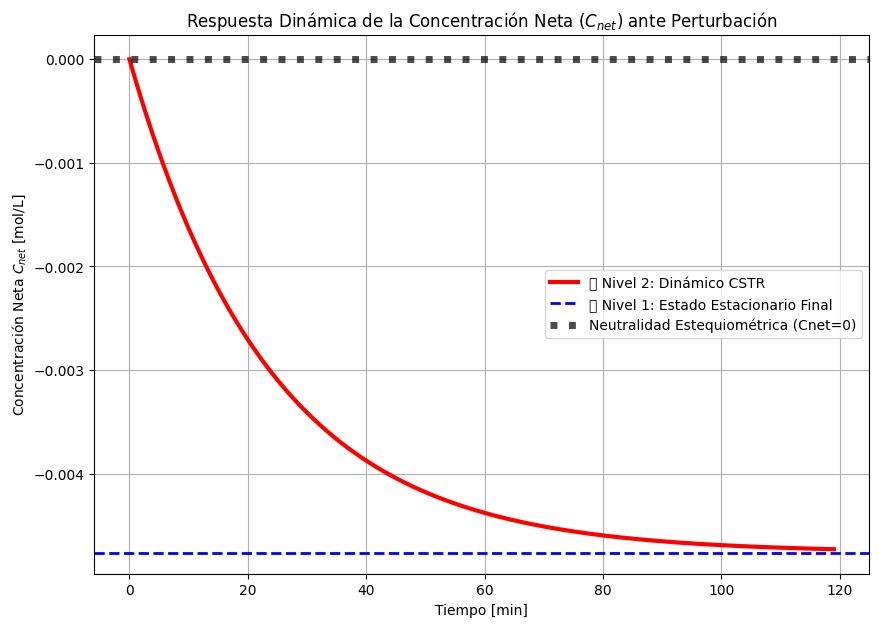


--- RESULTADOS DEL ANÁLISIS DINÁMICO ---
Constante de Tiempo del Reactor (τ): 23.81 min
--------------------------------------------------
🥉 Nivel 1 (Estado Estacionario): Cnet_final = -0.00476 mol/L
🥈 Nivel 2 (Dinámico): Cnet(t) se aproxima a -0.00473 mol/L
--------------------------------------------------
Análisis:
La concentración final es negativa, lo que indica un exceso de base.
La respuesta dinámica (Nivel 2) muestra que el sistema tarda aproximadamente 119.0 minutos en alcanzar el 95% del nuevo estado estacionario.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint



# =============================================================================
# 1. NIVEL 1: ESTADO ESTACIONARIO (VALOR FINAL)
# =============================================================================

# Concentración Neta Final (predicción del Nivel 1)
def Cnet_estacionario(VA_dot, CA_in, VB_dot_final, CB_in, V_dot_final):
  Cnet_final = (VA_dot * CA_in - VB_dot_final * CB_in) / V_dot_final

  return Cnet_final

# =============================================================================
# 2. NIVEL 2: EDO DINÁMICA (TRAYECTORIA CNET(t))
# =============================================================================

def dCnet_dt_nivel2(Cnet, t, V, VA_dot, VBdot_final, CA_in, CB_in):
    """
    EDO Nivel 2: Balance de Materia Dinámico para la Concentración Neta.
    dCnet/dt = 1/V * [ (Entrada Neta) - (Salida Total) ]
    """

    # Término de Entrada Neta (mol/min)
    Entrada_Neta = (VA_dot * CA_in) - (VBdot_final * CB_in)

    # Término de Salida (mol/min)
    V_dot = VA_dot + VB_dot_final
    Salida_Neta = V_dot * Cnet

    # EDO
    return (1 / V) * (Entrada_Neta - Salida_Neta)


# =============================================================================
# 3. PARÁMETROS DEL SISTEMA (CSTR Neutralización)
# =============================================================================
V = 500.0           # Volumen del reactor [L]
VA_dot = 10.0       # Flujo ácido entrante (constante) [L/min]
CA_in = 0.10        # Concentración de ácido entrante [mol/L]
CB_in = 0.10        # Concentración de base entrante [mol/L]

# Condiciones Iniciales
V_B_dot_initial = 10.0 # Flujo base inicial [L/min]
Cnet0 = 0.0          # Concentración Neta inicial (Neutralidad) [mol/L]

# Perturbación (Condiciones Finales)
V_B_dot_final = 11.0 # Flujo base final (después de la perturbación) [L/min]
V_dot_final = VA_dot + V_B_dot_final # Flujo total de salida [L/min]


# =============================================================================
# 4. SOLUCIÓN Y COMPARACIÓN
# =============================================================================
# Solución en estado estacionario (Nivel 1)
Cnet_final_N1 = Cnet_estacionario(VA_dot, CA_in, V_B_dot_final, CB_in, V_dot_final)

# Cálculo de la Constante de Tiempo (para definir el rango de tiempo)
tau = V / V_dot_final
t_sim_max = 5 * tau # Simular por 5 Constantes de Tiempo para alcanzar el 99%
t_sim = np.linspace(0, t_sim_max, 500)

# --- Solución Nivel 2 ---
args2 = (V, VA_dot, V_B_dot_final, CA_in, CB_in)
Cnet_sol_N2 = odeint(dCnet_dt_nivel2, Cnet0, t_sim, args=args2).flatten()

# =============================================================================
# 5. GRÁFICAS Y RESULTADOS
# =============================================================================

plt.figure(figsize=(10, 7))

# --- Gráfica Nivel 2 (Trayectoria dinámica) ---
plt.plot(t_sim, Cnet_sol_N2, label='🥈 Nivel 2: Dinámico CSTR', linestyle='-', color='red', linewidth=3)

# --- Gráfica Nivel 1 (Valor final como línea horizontal) ---
# El Nivel 1 predice el valor final al que debe llegar el Nivel 2
plt.axhline(Cnet_final_N1, label=f'🥉 Nivel 1: Estado Estacionario Final', linestyle='--', color='blue', linewidth=2)
plt.axhline(0.0, linestyle=':', alpha=0.7, label='Neutralidad Estequiométrica (Cnet=0)', color='black', linewidth=5)


plt.title('Respuesta Dinámica de la Concentración Neta ($C_{net}$) ante Perturbación')
plt.xlabel("Tiempo [min]")
plt.ylabel("Concentración Neta $C_{net}$ [mol/L]")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# RESULTADOS CLAVE
# =============================================================================
print("\n--- RESULTADOS DEL ANÁLISIS DINÁMICO ---")
print(f"Constante de Tiempo del Reactor (τ): {tau:.2f} min")
print("-" * 50)
print(f"🥉 Nivel 1 (Estado Estacionario): Cnet_final = {Cnet_final_N1:.5f} mol/L")
print(f"🥈 Nivel 2 (Dinámico): Cnet(t) se aproxima a {Cnet_sol_N2[-1]:.5f} mol/L")
print("-" * 50)
print("Análisis:")
print(f"La concentración final es negativa, lo que indica un exceso de base.")
print(f"La respuesta dinámica (Nivel 2) muestra que el sistema tarda aproximadamente {t_sim[np.argmin(np.abs(Cnet_sol_N2 - Cnet_final_N1))]:.1f} minutos en alcanzar el 95% del nuevo estado estacionario.")